In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression as SK_LogisticRegression
from sklearn.model_selection import train_test_split
import time

import sys
sys.path.append('../')
from supervised import LogisticRegression
from unsupervised.clustering import KMeans
from metrics import accuracy_score
from utils import generate_dataset_for_classification


CLASS_COLORS = {0: 'purple', 1: 'yellow'}

/Users/johnhenryrudden/anaconda3/envs/ml_mono/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Goals of this notebook

For this notebook, I hope to compare my own implementation of Logistic Regression with one implemented by scikit-learn. Although, before I do this I need some data to work with.

### Creating our dataset

I am not really sure the optimal approach to generating a dataset for classification. So, why not try a super naive yet simple approach.

__IMPLEMENTATION 1:__
Randomly init n centroids and generate points around each centroid using a normal distribution. Then, assign each point a label based on the centroid it is closest to (Use KMeans here). This last point is to remove overlap of data which will help for separability later.

See `data_utils.py` for implementation.


In [2]:
X, y = generate_dataset_for_classification(1000, 2, 2, center_box=(-10,10), random_state=2)

### Data splitting and Visualization

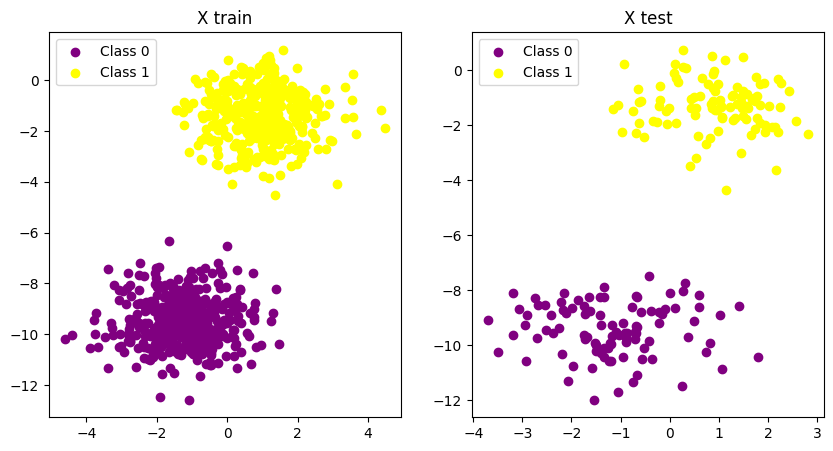

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Plot X train and X test
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
class_colors = {0: 'purple', 1: 'yellow'}

# Loop over each class and plot for both train and test sets
for class_value in [0, 1]:
    # Plot for X_train
    ax[0].scatter(X_train[y_train == class_value, 0], 
                  X_train[y_train == class_value, 1], 
                  color=CLASS_COLORS[class_value], 
                  label=f'Class {class_value}')
    
    # Plot for X_test
    ax[1].scatter(X_test[y_test == class_value, 0], 
                  X_test[y_test == class_value, 1], 
                  color=CLASS_COLORS[class_value], 
                  label=f'Class {class_value}')

ax[0].set_title("X train")
ax[0].legend()
ax[1].set_title("X test")
ax[1].legend()
plt.show()

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Training Time

With our classification data at hand, we're now set to train a Logistic Regression model.

#### How Does Logistic Regression Work?

Logistic Regression is primarily used for binary classification tasks. This model's high level goal is to learn the parameters of a function (such as a line in our simple case) that effectively separates samples from two distinct classes. 

**Key Steps in Logistic Regression:**

1. **Finding the Decision Boundary**: The model identifies a line (or decision boundary). The position of a sample relative to this line helps in classification: if it's on one side, it belongs to one class, and if it's on the other, it belongs to the second class.

2. **Probability Estimation Using Sigmoid Function**: The model maps the sample's input feature vector position relative to the learned line into a probability score using the sigmoid function (sigmoid function: $\sigma(x) = \frac{1}{1 + e^{-x}}$, maps values from $[-\infty, \infty]$ to the range $[0, 1]$). This score predicts the likelihood of a sample belonging to a particular class.

3. **Error Measurement with Binary Cross-Entropy**: To understand the model's accuracy, we use binary cross-entropy. This measures "how wrong" the model's predictions are compared to the actual classifications.

In summary, Logistic Regression is about learning the best way to draw a line that differentiates two classes. In a binary classification scenario, this line is optimized so that samples on one side are classified into one category, and those on the other side fall into the alternate category.


#### See `logistic_regression.py` for implementation details.

In [5]:
my_logreg = LogisticRegression()
time_start = time.time()
losses = my_logreg.fit(X_train, y_train, num_iterations=100_000)
time_end = time.time()
print(f"Training time: {time_end - time_start}s")

sk_logreg = SK_LogisticRegression()
time_start = time.time()
sk_logreg.fit(X_train, y_train)
time_end = time.time()
print(f"Training time: {time_end - time_start}s")

Training time: 1.8545799255371094s
Training time: 0.0025339126586914062s


In [6]:
my_preds_train = my_logreg.predict(X_train)
my_preds_test = my_logreg.predict(X_test)

sk_preds_train = sk_logreg.predict(X_train)
sk_preds_test = sk_logreg.predict(X_test)


my_acc_train = accuracy_score(y_train, my_preds_train)
my_acc_test = accuracy_score(y_test, my_preds_test)

sk_acc_train = accuracy_score(y_train, sk_preds_train)
sk_acc_test = accuracy_score(y_test, sk_preds_test)

print(f"My LR Model's Accuracy train: {my_acc_train}")
print(f"My LR Model's Accuracy test: {my_acc_test}")
print(f"SK LR Model's Accuracy train: {sk_acc_train}")
print(f"SK LR Model's Accuracy test: {sk_acc_test}")

My LR Model's Accuracy train: 1.0
My LR Model's Accuracy test: 1.0
SK LR Model's Accuracy train: 1.0
SK LR Model's Accuracy test: 1.0


In [7]:
# Function to plot the decision boundary and predictions of a logistic regression model
def plot_logistic_regression_probabilities(model, X_train, X_test, title):
    """
    Plots the decision boundary and probability predictions of a logistic regression model.

    Parameters:
    model: The logistic regression model (either custom or from Scikit-Learn).
    X_train, X_test: Training and testing datasets.
    """

    # Decision boundary calculation
    x_1_db = np.linspace(-10, 10, 1000)
    if hasattr(model, '_weights'):  # Custom model
        x_2_db = -(model._weights[1] * x_1_db + model._weights[0]) / model._weights[2]
    else:  # Scikit-Learn model
        x_2_db = -(model.coef_[0][0] * x_1_db + model.intercept_[0]) / model.coef_[0][1]

    # Probability predictions
    prob_preds_train = model.predict_proba(X_train)[:,1] # Probabilities for class 1
    prob_preds_test = model.predict_proba(X_test)[:,1] # Probabilities for class 1

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    scatter1 = ax[0].scatter(X_train[:, 0], X_train[:, 1], c=prob_preds_train, cmap='viridis')
    ax[0].set_title("X train")
    ax[0].plot(x_1_db, x_2_db, color='red', label='Decision Boundary')
    ax[0].set_xlim(np.min(X_train[:,0]) - 1, np.max(X_train[:,0]) + 1)
    ax[0].set_ylim(np.min(X_train[:,1]) - 1, np.max(X_train[:,1]) + 1)
    ax[0].legend()
    scatter2 = ax[1].scatter(X_test[:, 0], X_test[:, 1], c=prob_preds_test, cmap='viridis')
    ax[1].set_title("X test")
    ax[1].plot(x_1_db, x_2_db, color='red', label='Decision Boundary')
    ax[1].set_xlim(np.min(X_test[:,0]) - 1, np.max(X_test[:,0]) + 1)
    ax[1].set_ylim(np.min(X_test[:,1]) - 1, np.max(X_test[:,1]) + 1)
    ax[1].legend()
    
    # Normalize the color scale and add colorbar
    norm = Normalize(vmin=0.0, vmax=1.0)
    cbar = fig.colorbar(scatter1, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Probability of Class 1')
    fig.suptitle(title, size=16)
    plt.show()

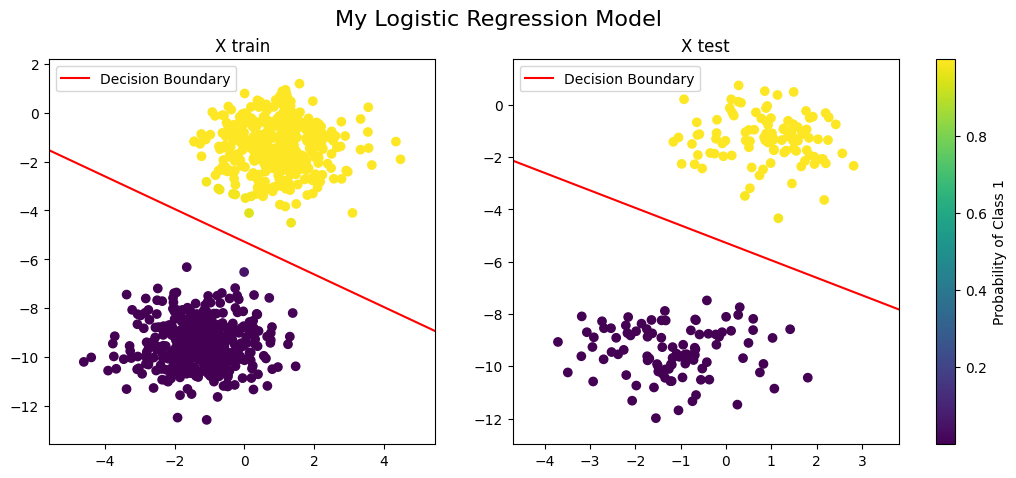

In [8]:
plot_logistic_regression_probabilities(my_logreg, X_train, X_test, title="My Logistic Regression Model")

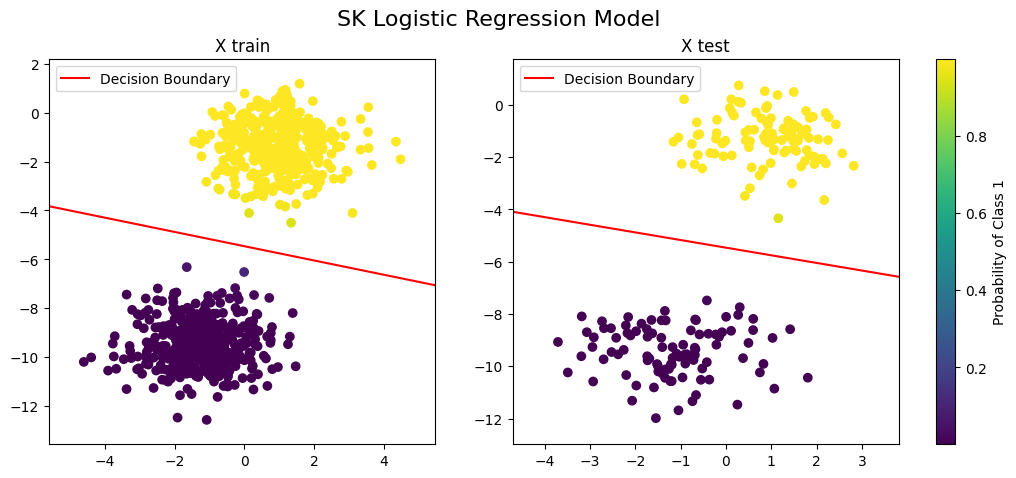

In [9]:
plot_logistic_regression_probabilities(sk_logreg, X_train, X_test, title="SK Logistic Regression Model")

### Evaluation and Comparison with Scikit-Learn

#### Efficiency and Speed
In comparing my implementation of Logistic Regression to the scikit-learn version, a key observation is the notable difference in efficiency and training speed. The scikit-learn model is significantly more efficient, which is to be expected.

#### Iteration Comparison
It is a little shocking to see the difference in the number of iterations needed to achieve comparable results. My implementation required approximately 100,000 iterations to converge to a similar level of classification 'sureness' as the scikit-learn model. In contrast, the default setting for scikit-learn's Logistic Regression is just 100 iterations. Which is a 1000x difference! Kinda crazy.